In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

## Single Particle MD

In [2]:
T = 10
t = 0.0005
v = 0.1 
a = 1
b = 2
m = 1
x = sp.symbols('x')
n = T/t

In [3]:
u = a*x**4 - b*x**2

In [4]:
roots = sp.solve(u,x)
print(roots)
expr = sp.Derivative(u,x)
du = expr.doit()
print(du)

[0, -sqrt(2), sqrt(2)]
4*x**3 - 4*x


In [5]:
du.subs(x,3)

96

In [6]:
initial_x = roots[1]

In [7]:
n_dash = int(n)
velocities = np.zeros((n_dash+1, 1))
positions = np.zeros((n_dash+1, 1))
forces = np.zeros((n_dash+1,1))
energies = np.zeros((n_dash+1,1))

In [8]:
n_dash

20000

In [9]:
velocities[0] = v
positions[0] = initial_x
forces [0] = 0

In [10]:
position_value = float(positions[0]) 
pe_new = u.subs(x,position_value).evalf()
print(pe_new)

0


/tmp/ipykernel_11215/3955492192.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  position_value = float(positions[0])


In [11]:
energies[0] = (1/2)*m*(v**2)
    

In [12]:
energies

array([[0.005],
       [0.   ],
       [0.   ],
       ...,
       [0.   ],
       [0.   ],
       [0.   ]])

In [13]:
for i in range(n_dash):
    positions[i+1] = positions[i]+ velocities[i]*t + (t**2/2*m)*forces[i]
    position_value = float(positions[i+1,0])
#     print(positions[i+1])
#     print(position_value)
    force_value = du.subs(x, position_value).evalf()
    forces[i+1] = -1 * float(force_value)    
    velocities[i+1] = velocities[i] + (t/(2*m))*(forces[i]+forces[i+1])
    pe_new = u.subs(x,position_value).evalf()
    w = velocities[i+1]
    ke_new = (1/2)*m*(w**2)
    energies[i+1] = pe_new + ke_new
    

In [14]:
positions

array([[-1.41421356],
       [-1.41416356],
       [-1.41411215],
       ...,
       [-0.86577936],
       [-0.86509312],
       [-0.8644071 ]])

In [15]:
velocities

array([[0.1       ],
       [0.10141396],
       [0.10424163],
       ...,
       [1.37269504],
       [1.37226055],
       [1.37182436]])

In [16]:
forces

array([[ 0.        ],
       [ 5.65585429],
       [ 5.65482614],
       ...,
       [-0.86725499],
       [-0.87067778],
       [-0.87408972]])

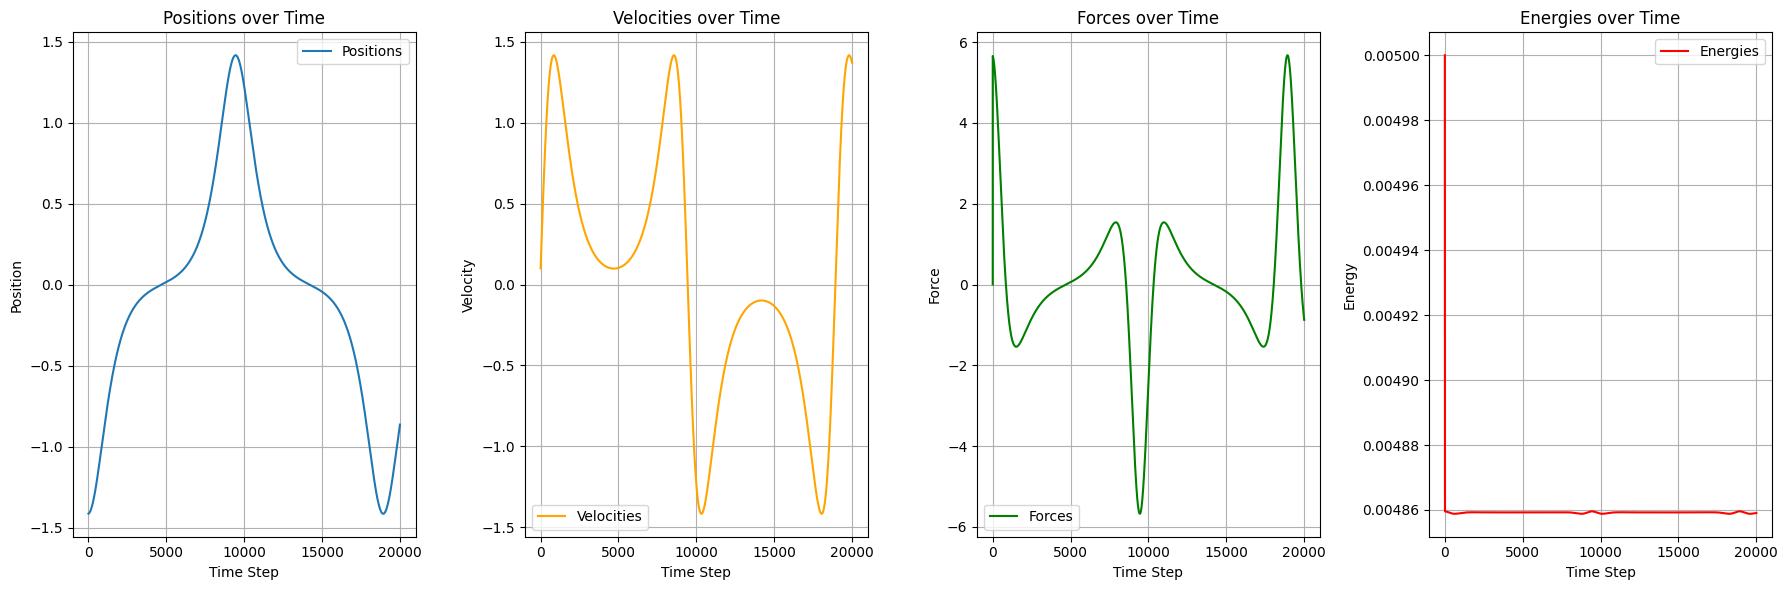

In [17]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.plot(range(n_dash + 1), positions, label='Positions')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('Positions over Time')
plt.grid(True)
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(range(n_dash + 1), velocities, label='Velocities', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.title('Velocities over Time')
plt.grid(True)
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(range(n_dash + 1), forces, label='Forces', color='green')
plt.xlabel('Time Step')
plt.ylabel('Force')
plt.title('Forces over Time')
plt.grid(True)
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(range(n_dash + 1), energies, label='Energies', color='red')
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.title('Energies over Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Multi Particle MD

In [18]:
def initialize_positions(num_particles, box_size):
    positions = np.random.rand(num_particles, 3) * box_size
    return positions


In [19]:
def lennard_jones_potential(r, epsilon=1.0, sigma=1.0, r_cut=2.5,small_constant=1e-9):
    r = max(r, small_constant)
    if r < r_cut:
        U = 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)
        U_shift = 4 * epsilon * ((sigma / r_cut)**12 - (sigma / r_cut)**6)
        return U - U_shift
    else:
        return 0.0


In [20]:
def total_potential_energy_for_particle(positions, dim,time_step,particle_index, box_size, epsilon=1.0, sigma=1.0, r_cut=2.5):
    num_particles = positions.shape[1]
    energy = 0.0
    for j in range(num_particles-1):
        if j != particle_index:  
            rij = positions[time_step][particle_index][dim] - positions[time_step][j][dim]
            rij -= box_size * np.round(rij / box_size) 
            r = np.linalg.norm(rij)
            if r < r_cut:
                energy += lennard_jones_potential(r, epsilon, sigma, r_cut)
    return r,energy

In [21]:
T = 10
t = 0.0005
r = sp.symbols('r')
epsilon = 1.0
sigma = 1.0
r_cut = 2.5
n = T/t
n_dash = int(n)
num_particles = 10
box_size = 10.0
m = 1
U = 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)
v = np.random.randn(num_particles,3)

In [22]:
expr = sp.Derivative(U,r)
dU = expr.doit()
print(dU)

24.0/r**7 - 48.0/r**13


In [23]:
positions = np.zeros((n_dash+1, num_particles, 3))
velocities = np.zeros((n_dash+1, num_particles, 3))
forces = np.zeros((n_dash+1, num_particles, 3))
energies = np.zeros((n_dash+1, num_particles, 1))
sum_vels_squared = 0
i_p = initialize_positions(num_particles,box_size)
positions[0, :, :] = i_p
velocities[0,:,:] = v
for i in range(num_particles):
    rx,pex = total_potential_energy_for_particle(positions,0,0,i, box_size)
    ry,pey = total_potential_energy_for_particle(positions,1,0,i, box_size)
    rz,pez = total_potential_energy_for_particle(positions,2,0,i, box_size)
    pe_vec = np.array([pex,pey,pez])
    r_vec = np.array([rx,ry,rz])
    pe  = np.linalg.norm(pe_vec)
    ra = np.linalg.norm(r_vec)
    ke = 0.5 * np.linalg.norm(v[i])**2
    vv = np.linalg.norm(v[i])**2
    sum_vels_squared+=vv
    et = pe+ke
    fxt = dU.subs(r,rx).evalf()
    fyt = dU.subs(r,ry).evalf()
    fzt = dU.subs(r,rz).evalf()
    fx = -1*float(fxt)
    fy = -1*float(fyt)
    fz = -1*float(fzt)
    forces[0,i,0] = fx
    forces[0,i,1] = fy
    forces[0,i,2] = fz
    energies[0,i,0] = et
    
temp = sum_vels_squared/num_particles


In [24]:
for i in range(n_dash):
    for j in range(num_particles):
        positions[i+1][j][0] = positions[i][j][0]+ velocities[i][j][0]*t + (t**2/2*m)*forces[i][j][0]
        positions[i+1][j][1] = positions[i][j][1]+ velocities[i][j][1]*t + (t**2/2*m)*forces[i][j][1]
        positions[i+1][j][2] = positions[i][j][2]+ velocities[i][j][2]*t + (t**2/2*m)*forces[i][j][2]        
        px = positions[i+1][j][0]
        py = positions[i+1][j][1]
        pz = positions[i+1][j][2]
        
        fxt = dU.subs(r,px).evalf()
        fyt = dU.subs(r,py).evalf()
        fzt = dU.subs(r,pz).evalf()
        fx = -1*float(fxt)
        fy = -1*float(fyt)
        fz = -1*float(fzt)
        forces[i+1,j,0] = fx
        forces[i+1,j,1] = fy
        forces[i+1,j,2] = fz
        velocities[i+1][j][0] = velocities[i][j][0] + (t/(2*m))*(forces[i][j][0]+forces[i+1][j][0])
        velocities[i+1][j][1] = velocities[i][j][1] + (t/(2*m))*(forces[i][j][1]+forces[i+1][j][1])
        velocities[i+1][j][2] = velocities[i][j][2] + (t/(2*m))*(forces[i][j][2]+forces[i+1][j][2])
        
        rx,pex = total_potential_energy_for_particle(positions,0,0,j, box_size)
        ry,pey = total_potential_energy_for_particle(positions,1,0,j, box_size)
        rz,pez = total_potential_energy_for_particle(positions,2,0,j, box_size)
        pe_vec = np.array([pex,pey,pez])
        r_vec = np.array([rx,ry,rz])
        pe  = np.linalg.norm(pe_vec)
        ra = np.linalg.norm(r_vec)
        ke = 0.5 * np.linalg.norm(velocities[i+1][j])**2
        et = pe+ke
        energies[i+1,j,0] = et
        
    

In [25]:
positions

array([[[4.03041128e+00, 9.57146477e+00, 8.07779039e+00],
        [7.56851482e+00, 3.04413389e+00, 7.42175743e+00],
        [6.68743045e-01, 9.21793859e+00, 2.13629191e+00],
        ...,
        [7.72009411e+00, 4.37580192e+00, 4.07914892e+00],
        [3.14716812e+00, 5.66528983e+00, 7.43007225e+00],
        [9.15092277e+00, 4.68657406e+00, 1.74119272e+00]],

       [[4.02989473e+00, 9.57085208e+00, 8.08060932e+00],
        [7.56958014e+00, 3.04401755e+00, 6.60795069e+21],
        [6.69742430e-01, 9.21859369e+00, 2.13607895e+00],
        ...,
        [7.72069670e+00, 4.37531337e+00, 4.07945931e+00],
        [3.14694918e+00, 5.66614042e+00, 7.43065451e+00],
        [9.15065433e+00, 4.68670929e+00, 1.74244729e+00]],

       [[4.02937819e+00, 9.57023939e+00, 8.08342825e+00],
        [7.57064545e+00, 3.04390122e+00, 1.32159014e+22],
        [6.72842332e-01, 9.21924879e+00, 2.13586596e+00],
        ...,
        [7.72129930e+00, 4.37482481e+00, 4.07976969e+00],
        [3.14673024e+00, 5.66

In [26]:
energies

array([[[1.22475967e+06],
        [3.66292634e+25],
        [1.06509187e+06],
        ...,
        [2.71881324e+10],
        [3.66292634e+25],
        [3.38154247e+14]],

       [[1.22477271e+06],
        [8.73300245e+49],
        [1.06509828e+06],
        ...,
        [2.71881324e+10],
        [3.66292634e+25],
        [3.38154247e+14]],

       [[1.22477271e+06],
        [8.73300245e+49],
        [1.06512329e+06],
        ...,
        [2.71881324e+10],
        [3.66292634e+25],
        [3.38154247e+14]],

       ...,

       [[1.22477271e+06],
        [8.73300245e+49],
        [1.06554433e+06],
        ...,
        [2.71881324e+10],
        [3.66292634e+25],
        [3.38154247e+14]],

       [[1.22477271e+06],
        [8.73300245e+49],
        [1.06554433e+06],
        ...,
        [2.71881324e+10],
        [3.66292634e+25],
        [3.38154247e+14]],

       [[1.22477271e+06],
        [8.73300245e+49],
        [1.06554433e+06],
        ...,
        [2.71881324e+10],
        [3.6629

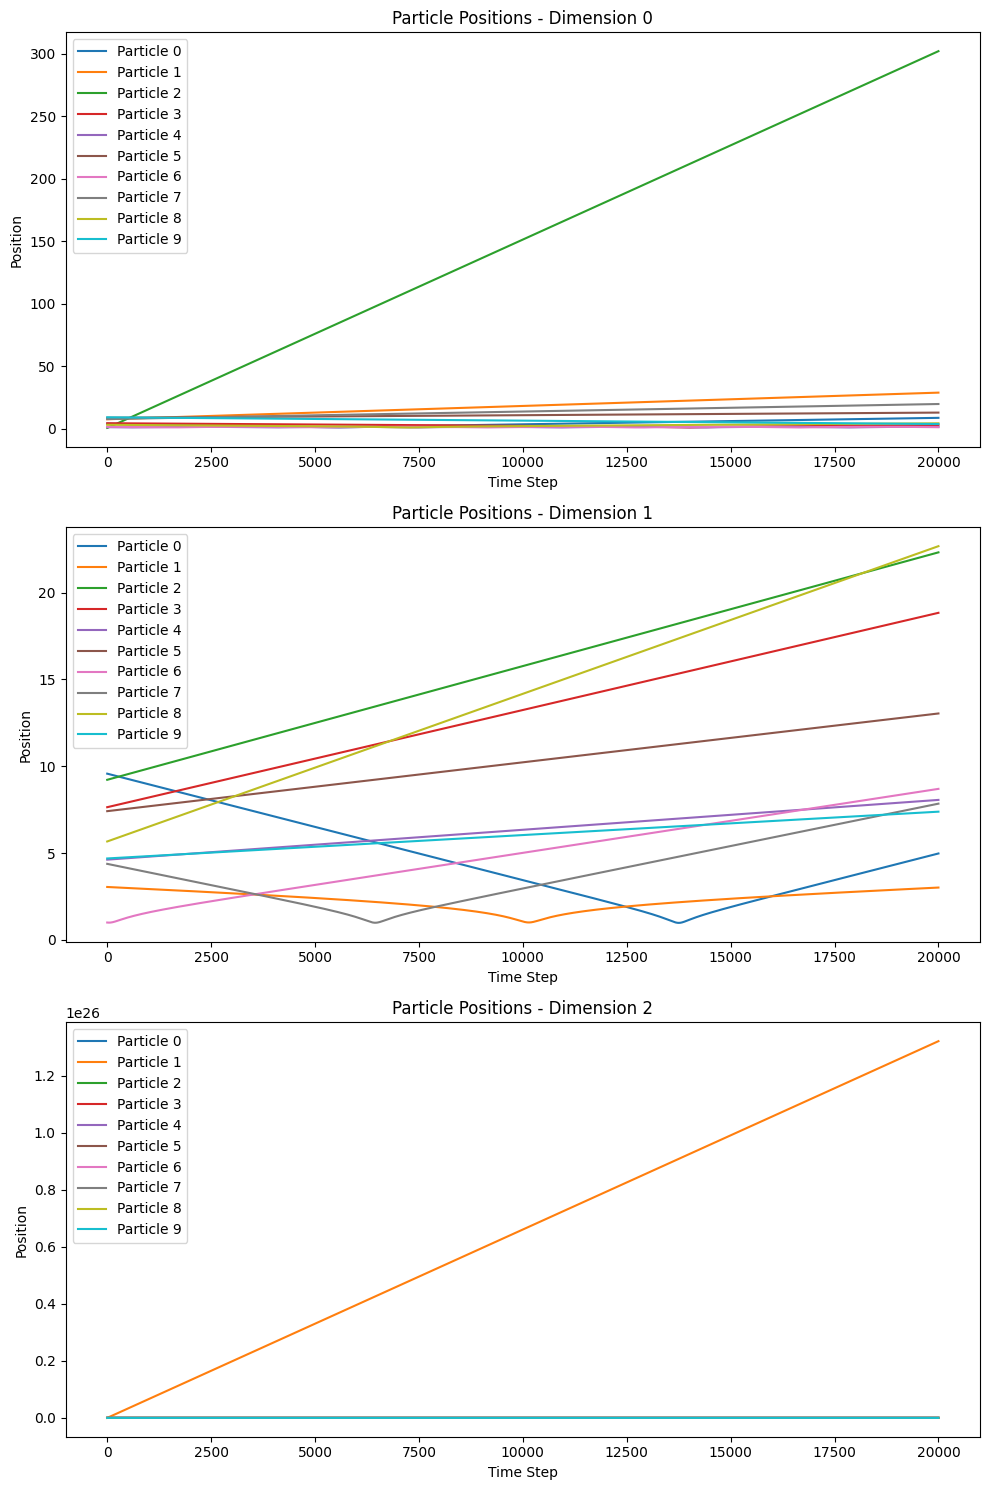

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
for dim in range(3):
    axs[dim].set_title(f'Particle Positions - Dimension {dim}')
    for particle in range(num_particles):
        axs[dim].plot(range(n_dash + 1), positions[:, particle, dim], label=f'Particle {particle}')
    axs[dim].set_xlabel('Time Step')
    axs[dim].set_ylabel('Position')
    axs[dim].legend()

plt.tight_layout()
plt.show()


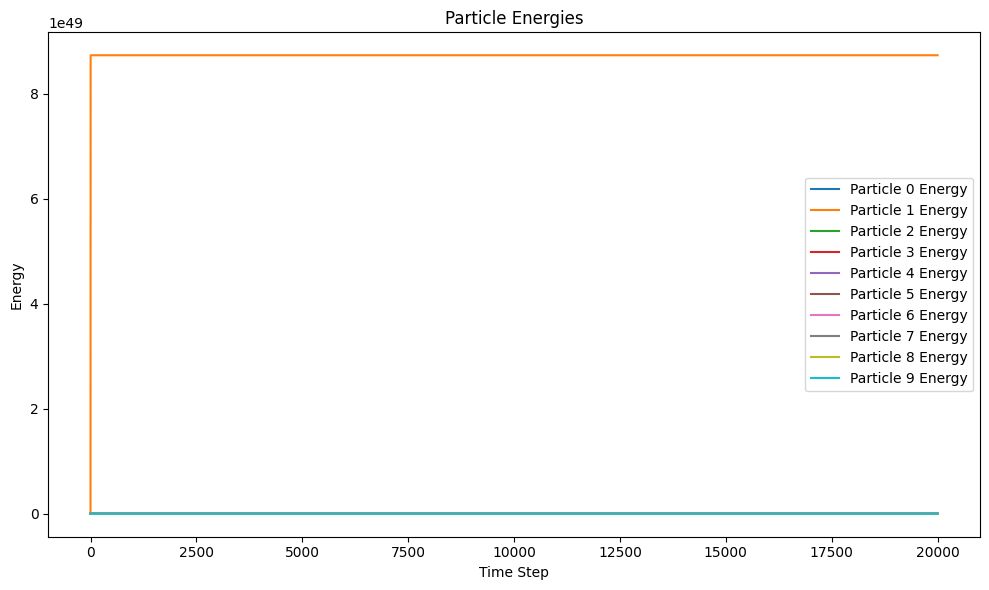

In [28]:
# Plotting energies
fig, axs = plt.subplots(figsize=(10, 6))
axs.set_title('Particle Energies')
for particle in range(num_particles):
    axs.plot(range(n_dash + 1), energies[:, particle, 0], label=f'Particle {particle} Energy')
axs.set_xlabel('Time Step')
axs.set_ylabel('Energy')
axs.legend()

plt.tight_layout()
plt.show()

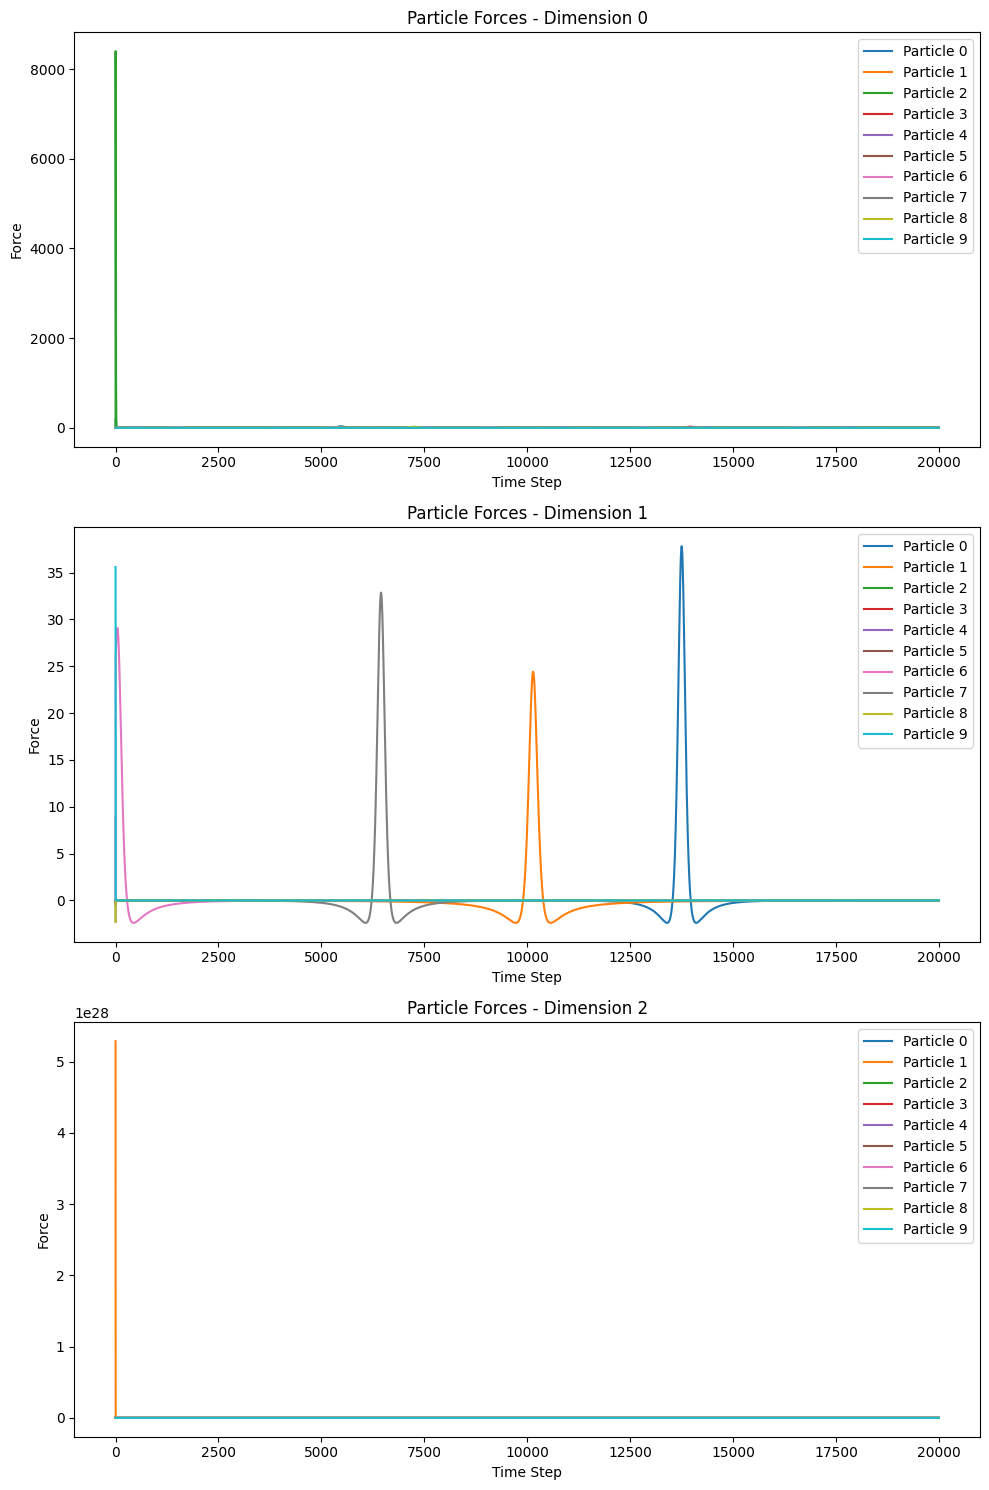

In [29]:
# Plotting forces
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
for dim in range(3):
    axs[dim].set_title(f'Particle Forces - Dimension {dim}')
    for particle in range(num_particles):
        axs[dim].plot(range(n_dash + 1), forces[:, particle, dim], label=f'Particle {particle}')
    axs[dim].set_xlabel('Time Step')
    axs[dim].set_ylabel('Force')
    axs[dim].legend()

plt.tight_layout()
plt.show()

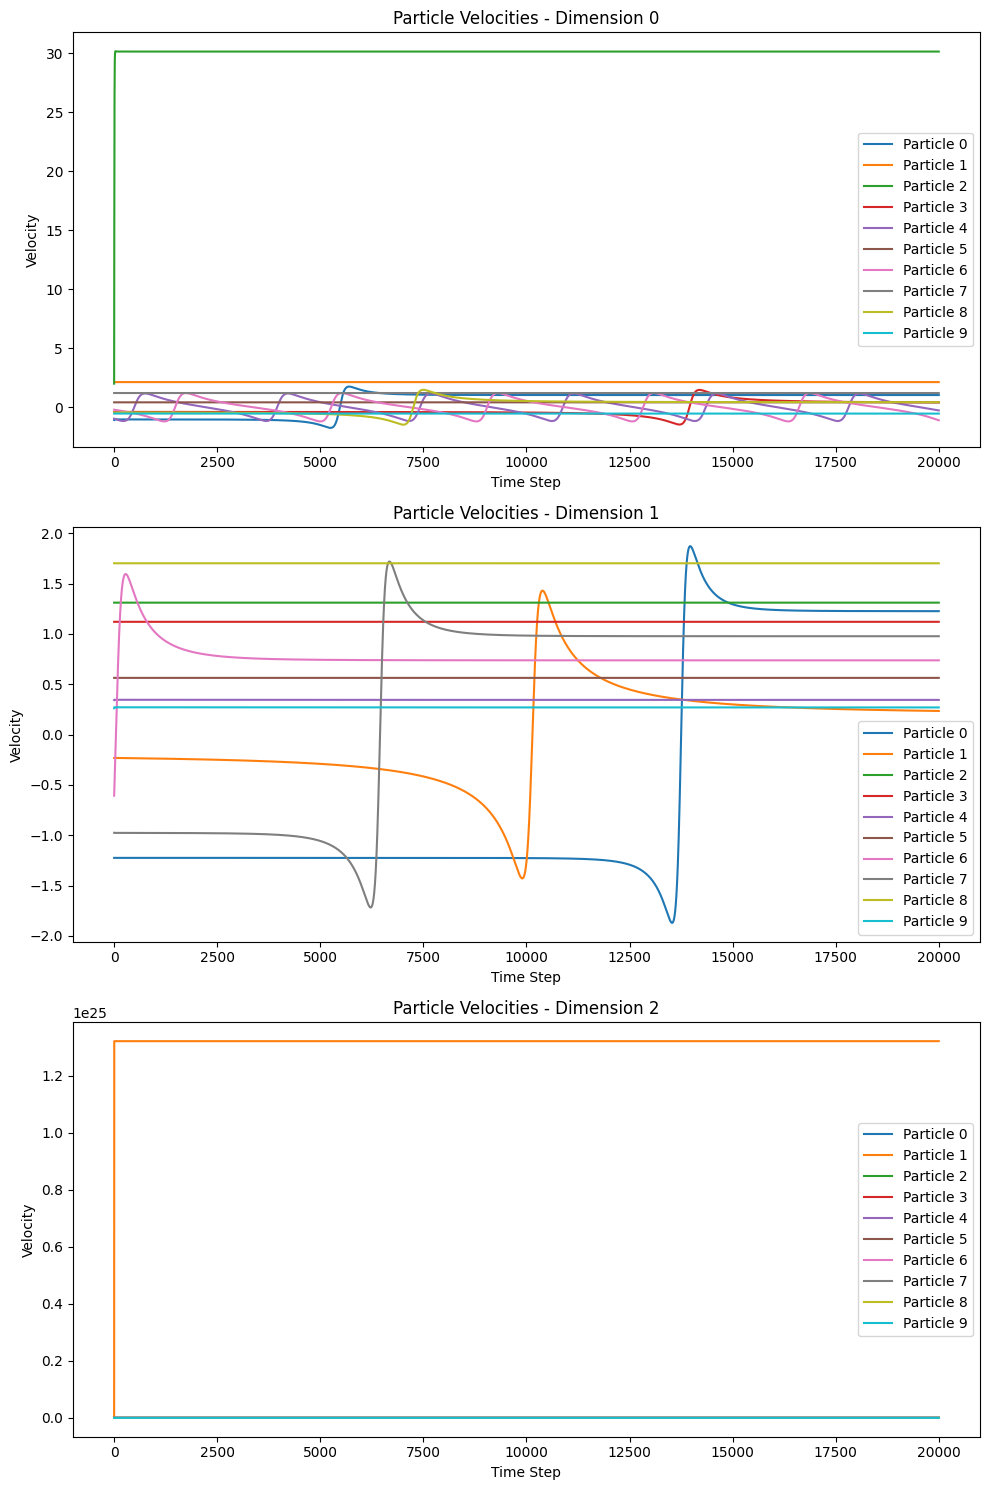

In [30]:
# Plotting velocities
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
for dim in range(3):
    axs[dim].set_title(f'Particle Velocities - Dimension {dim}')
    for particle in range(num_particles):
        axs[dim].plot(range(n_dash + 1), velocities[:, particle, dim], label=f'Particle {particle}')
    axs[dim].set_xlabel('Time Step')
    axs[dim].set_ylabel('Velocity')
    axs[dim].legend()

plt.tight_layout()
plt.show()

In [31]:
def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

## Anderson Thermostat

In [32]:
nu = 500000
desired_temperature = 10.0

In [33]:
def calculate_temperature(velocities, mass=1.0, k_B=1.0):
    kinetic_energy = 0.5 * mass * np.sum(velocities**2) / num_particles
    temperature = (2.0 / 3.0) * kinetic_energy / k_B
    return temperature


In [34]:
positions = np.zeros((n_dash+1, num_particles, 3))
velocities = np.zeros((n_dash+1, num_particles, 3))
forces = np.zeros((n_dash+1, num_particles, 3))
energies = np.zeros((n_dash+1, num_particles, 1))
temperatures = np.zeros(n_dash + 1)
sum_vels_squared = 0
i_p = initialize_positions(num_particles,box_size)
positions[0, :, :] = i_p
velocities[0,:,:] = np.random.normal(loc=0.0, scale=np.sqrt(desired_temperature), size=(num_particles, 3))
for i in range(num_particles):
    rx,pex = total_potential_energy_for_particle(positions,0,0,i, box_size)
    ry,pey = total_potential_energy_for_particle(positions,1,0,i, box_size)
    rz,pez = total_potential_energy_for_particle(positions,2,0,i, box_size)
    pe_vec = np.array([pex,pey,pez])
    r_vec = np.array([rx,ry,rz])
    pe  = np.linalg.norm(pe_vec)
    ra = np.linalg.norm(r_vec)
    ke = 0.5 * np.linalg.norm(v[i])**2
    vv = np.linalg.norm(v[i])**2
    sum_vels_squared+=vv
    et = pe+ke
    fxt = dU.subs(r,rx).evalf()
    fyt = dU.subs(r,ry).evalf()
    fzt = dU.subs(r,rz).evalf()
    fx = -1*float(fxt)
    fy = -1*float(fyt)
    fz = -1*float(fzt)
    forces[0,i,0] = fx
    forces[0,i,1] = fy
    forces[0,i,2] = fz
    energies[0,i,0] = et
    



In [35]:
velocities

array([[[-1.91494835,  1.93913993,  1.97655482],
        [-4.99928402,  3.09459996,  2.58803838],
        [ 4.3111146 ,  6.99244164, -5.19021339],
        ...,
        [-2.40294022, -0.73105833,  4.63909862],
        [ 5.55325878, -8.1882744 ,  0.19278271],
        [ 4.12556871, -0.71069045,  0.77389158]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        ,  0.        ],
        [ 0

In [36]:
for i in range(n_dash):    
    for j in range(num_particles):
        positions[i+1][j][0] = positions[i][j][0]+ velocities[i][j][0]*t + (t**2/2*m)*forces[i][j][0]
        positions[i+1][j][1] = positions[i][j][1]+ velocities[i][j][1]*t + (t**2/2*m)*forces[i][j][1]
        positions[i+1][j][2] = positions[i][j][2]+ velocities[i][j][2]*t + (t**2/2*m)*forces[i][j][2]        
        px = positions[i+1][j][0]
        py = positions[i+1][j][1]
        pz = positions[i+1][j][2]        
        fxt = dU.subs(r,px).evalf()
        fyt = dU.subs(r,py).evalf()
        fzt = dU.subs(r,pz).evalf()
        fx = -1*float(fxt)
        fy = -1*float(fyt)
        fz = -1*float(fzt)
        forces[i+1,j,0] = fx
        forces[i+1,j,1] = fy
        forces[i+1,j,2] = fz
        if np.random.rand()<nu*t:
            velocities[i+1, j] = np.random.normal(loc=0.0, scale=np.sqrt(desired_temperature), size=3)
#             print("hello")
        else:
            velocities[i+1][j][0] = velocities[i][j][0] + (t/(2*m))*(forces[i][j][0]+forces[i+1][j][0])
            velocities[i+1][j][1] = velocities[i][j][1] + (t/(2*m))*(forces[i][j][1]+forces[i+1][j][1])
            velocities[i+1][j][2] = velocities[i][j][2] + (t/(2*m))*(forces[i][j][2]+forces[i+1][j][2])              
        rx,pex = total_potential_energy_for_particle(positions,0,0,j, box_size)
        ry,pey = total_potential_energy_for_particle(positions,1,0,j, box_size)
        rz,pez = total_potential_energy_for_particle(positions,2,0,j, box_size)
        pe_vec = np.array([pex,pey,pez])
        r_vec = np.array([rx,ry,rz])
        pe  = np.linalg.norm(pe_vec)
        ra = np.linalg.norm(r_vec)
        ke = 0.5 * np.linalg.norm(velocities[i+1][j])**2
        sum_vels_squared+=np.linalg.norm(velocities[i+1][j])**2
        et = pe+ke
        energies[i+1,j,0] = et
    temperatures[i+1] = calculate_temperature(velocities[i+1])
        
    

In [37]:
velocities

array([[[-1.91494835e+00,  1.93913993e+00,  1.97655482e+00],
        [-4.99928402e+00,  3.09459996e+00,  2.58803838e+00],
        [ 4.31111460e+00,  6.99244164e+00, -5.19021339e+00],
        ...,
        [-2.40294022e+00, -7.31058333e-01,  4.63909862e+00],
        [ 5.55325878e+00, -8.18827440e+00,  1.92782709e-01],
        [ 4.12556871e+00, -7.10690450e-01,  7.73891581e-01]],

       [[ 1.68247199e-01,  1.94861847e-01, -1.77525143e+00],
        [ 2.46747421e+00, -2.09120018e+00, -2.63320212e+00],
        [-8.70125329e-01,  1.28270813e+00, -6.97965544e+00],
        ...,
        [ 2.99345394e+00, -5.26361972e-01, -2.12973372e+00],
        [ 7.76713927e-01, -3.54848698e-01, -1.09598049e+00],
        [ 3.45122101e+00,  4.24613936e+00, -1.29358288e+00]],

       [[ 4.72382259e+00,  2.28730726e+00, -7.87094122e-01],
        [ 4.32797934e+00, -6.01388095e+00,  1.46787345e+00],
        [ 4.68712122e+00,  1.69755161e+00,  9.72221044e-01],
        ...,
        [-1.89476919e+00,  2.24645250e+00,

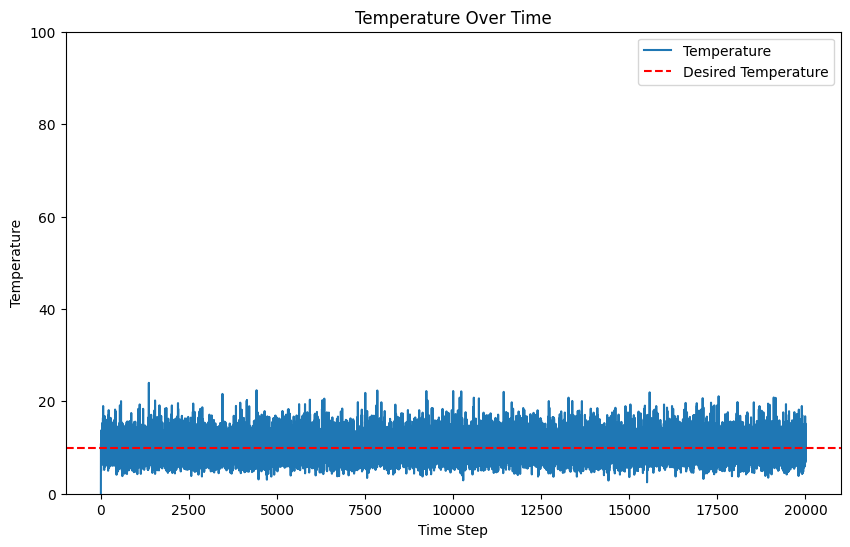

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(range(n_dash + 1), temperatures, label='Temperature')
plt.axhline(y=desired_temperature, color='r', linestyle='--', label='Desired Temperature')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.ylim(0, 100)  
plt.show()

## REMD 

In [40]:
temp1 = 100.0
temp2 = 200.0
temp3 = 300.0
temp4 = 400.0
box_size = 10
n_dash = 1000
attempts = [0, 0, 0]  # For pairs (1-2), (2-3), (3-4)
accepted = [0, 0, 0]

In [41]:
def total_potential_energy(positions, box_size, epsilon=1.0, sigma=1.0, r_cut=2.5):
    num_particles = positions.shape[1]
    energy = 0.0
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            rij = positions[i] - positions[j]
            rij -= box_size * np.round(rij / box_size)  # Apply minimum image convention
            r = np.linalg.norm(rij)
            if r < r_cut:
                energy += lennard_jones_potential(r, epsilon, sigma, r_cut)
    return energy

def calculate_acceptance_ratio(attempts, accepted):
    print(attempts)
    print(accepted)
    return accepted / attempts if attempts > 0 else 0.0






In [42]:
def initialise_REMD(n_dash,num_particles,desired_temperature):
    positions = np.zeros((n_dash+1, num_particles, 3))
    velocities = np.zeros((n_dash+1, num_particles, 3))
    forces = np.zeros((n_dash+1, num_particles, 3))
    energies = np.zeros((n_dash+1, num_particles, 1))
    temperatures = np.zeros(n_dash + 1)
    temperatures[0] = desired_temperature
    sum_vels_squared = 0
    i_p = initialize_positions(num_particles,box_size)
    positions[0, :, :] = i_p
    velocities[0,:,:] = np.random.normal(loc=0.0, scale=np.sqrt(desired_temperature), size=(num_particles, 3))
    for i in range(num_particles):
        rx,pex = total_potential_energy_for_particle(positions,0,0,i, box_size)
        ry,pey = total_potential_energy_for_particle(positions,1,0,i, box_size)
        rz,pez = total_potential_energy_for_particle(positions,2,0,i, box_size)
        pe_vec = np.array([pex,pey,pez])
        r_vec = np.array([rx,ry,rz])
        pe  = np.linalg.norm(pe_vec)
        ra = np.linalg.norm(r_vec)
        ke = 0.5 * np.linalg.norm(v[i])**2
        vv = np.linalg.norm(v[i])**2
        sum_vels_squared+=vv
        et = pe+ke
        fxt = dU.subs(r,rx).evalf()
        fyt = dU.subs(r,ry).evalf()
        fzt = dU.subs(r,rz).evalf()
        fx = -1*float(fxt)
        fy = -1*float(fyt)
        fz = -1*float(fzt)
        forces[0,i,0] = fx
        forces[0,i,1] = fy
        forces[0,i,2] = fz
        energies[0,i,0] = et
    return positions,velocities,forces,energies,temperatures
    


    

In [43]:
def run_REMD(i,j,desired_temperature,positions,velocities,forces,energies,temperatures):
        positions[i+1][j][0] = positions[i][j][0]+ velocities[i][j][0]*t + (t**2/2*m)*forces[i][j][0]
        positions[i+1][j][1] = positions[i][j][1]+ velocities[i][j][1]*t + (t**2/2*m)*forces[i][j][1]
        positions[i+1][j][2] = positions[i][j][2]+ velocities[i][j][2]*t + (t**2/2*m)*forces[i][j][2]        
        px = positions[i+1][j][0]
        py = positions[i+1][j][1]
        pz = positions[i+1][j][2]        
        fxt = dU.subs(r,px).evalf()
        fyt = dU.subs(r,py).evalf()
        fzt = dU.subs(r,pz).evalf()
        fx = -1*float(fxt)
        fy = -1*float(fyt)
        fz = -1*float(fzt)
        forces[i+1,j,0] = fx
        forces[i+1,j,1] = fy
        forces[i+1,j,2] = fz
        if np.random.rand()<nu*t:
            velocities[i+1, j] = np.random.normal(loc=0.0, scale=np.sqrt(desired_temperature), size=3)
#             print("hello")
        else:
            velocities[i+1][j][0] = velocities[i][j][0] + (t/(2*m))*(forces[i][j][0]+forces[i+1][j][0])
            velocities[i+1][j][1] = velocities[i][j][1] + (t/(2*m))*(forces[i][j][1]+forces[i+1][j][1])
            velocities[i+1][j][2] = velocities[i][j][2] + (t/(2*m))*(forces[i][j][2]+forces[i+1][j][2])              
        rx,pex = total_potential_energy_for_particle(positions,0,0,j, box_size)
        ry,pey = total_potential_energy_for_particle(positions,1,0,j, box_size)
        rz,pez = total_potential_energy_for_particle(positions,2,0,j, box_size)
        pe_vec = np.array([pex,pey,pez])
        r_vec = np.array([rx,ry,rz])
        pe  = np.linalg.norm(pe_vec)
        ra = np.linalg.norm(r_vec)
        ke = 0.5 * np.linalg.norm(velocities[i+1][j])**2
#         sum_vels_squared+=np.linalg.norm(velocities[i+1][j])**2
        et = pe+ke
        energies[i+1,j,0] = et
#         temperatures[i+1] = calculate_temperature(velocities[i+1])
        return positions,velocities,forces,energies
        
    
    

In [44]:
positions,velocities,forces,energies,temperatures = initialise_REMD(n_dash,num_particles,temp1)
positions2,velocities2,forces2,energies2,temperatures2 = initialise_REMD(n_dash,num_particles,temp2)
positions3,velocities3,forces3,energies3,temperatures3 = initialise_REMD(n_dash,num_particles,temp3)
positions4,velocities4,forces4,energies4,temperatures4 = initialise_REMD(n_dash,num_particles,temp4)

tmp_list = [[temperatures,positions],[temperatures2,positions2],[temperatures3,positions3],[temperatures4,positions4]]

In [45]:
successful = 0
for i in range(n_dash):
    for j in range(num_particles):
        run_REMD(i,j,temp1,positions,velocities,forces,energies,temperatures)
        run_REMD(i,j,temp2,positions2,velocities2,forces2,energies2,temperatures2)
        run_REMD(i,j,temp3,positions3,velocities3,forces3,energies3,temperatures3)
        run_REMD(i,j,temp4,positions4,velocities4,forces4,energies4,temperatures4)
    temperatures[i+1] = calculate_temperature(velocities[i+1])
    temperatures2[i+1] = calculate_temperature(velocities2[i+1])
    temperatures3[i+1] = calculate_temperature(velocities3[i+1])
    temperatures4[i+1] = calculate_temperature(velocities4[i+1])
    ls = [0,1,2,3]
    y = random.choice(ls)
    prev = y-1
    nxt = y+1
    if prev<0 or nxt >3:
        continue
    if tmp_list[y][0][i+1]<tmp_list[nxt][0][i+1] and nxt<=3:
        pe1 = total_potential_energy(tmp_list[y][1][i+1],box_size)
        pe2 = total_potential_energy(tmp_list[nxt][1][i+1],box_size)
        ww1 = 1/(tmp_list[y][0][i+1])
        ww2 = 1/(tmp_list[nxt][0][i+1])
        delta_energy = (ww1-ww2)*(pe2-pe1)
        needed_expr = np.exp(-delta_energy)
        if np.random.rand()<needed_expr:
            successful+=1
            tmpp = tmp_list[y][0][i+1]
            tmp_list[y][0][i+1] = tmp_list[nxt][0][i+1]
            tmp_list[nxt][0][i+1] = tmp_list[y][0][i+1]
            print(f"Switch between {y} and {nxt}")
            continue
        else:
            continue
    elif tmp_list[y][0][i+1]>tmp_list[prev][0][i+1] and prev>=0:
        pe1 = total_potential_energy(tmp_list[y][1][i+1],box_size)
        pe2 = total_potential_energy(tmp_list[prev][1][i+1],box_size)
        ww1 = 1/(tmp_list[y][0][i+1])
        ww2 = 1/(tmp_list[prev][0][i+1])
        delta_energy = (ww1-ww2)*(pe2-pe1)
        delta_energy = ((1/(tmp_list[y][0][i+1]))-(1/(tmp_list[prev][0][i+1])))*(pe2-pe1)
        needed_expr = np.exp(-delta_energy)
        if np.random.rand()<needed_expr:
            successful+=1
            tmpp = tmp_list[y][0][i+1]
            tmp_list[y][0][i+1] = tmp_list[prev][0][i+1]
            tmp_list[prev][0][i+1] = tmp_list[y][0][i+1]
            print(f"Switch between {y} and {prev}")
            continue
        else:
            continue
    
    
    
    
print(f"The success are {successful}")
    

Switch between 1 and 2
Switch between 2 and 3
Switch between 2 and 3
Switch between 1 and 2
Switch between 1 and 2
Switch between 1 and 2
Switch between 1 and 0
Switch between 1 and 0
Switch between 2 and 3
Switch between 1 and 0
Switch between 2 and 3
Switch between 1 and 2
Switch between 2 and 1
Switch between 2 and 3
Switch between 1 and 2
Switch between 1 and 2
Switch between 2 and 3
Switch between 1 and 2
Switch between 2 and 1
Switch between 1 and 2
Switch between 2 and 3
Switch between 2 and 1
Switch between 2 and 3
Switch between 1 and 2
Switch between 2 and 3
Switch between 2 and 1
Switch between 1 and 2
Switch between 2 and 3
Switch between 2 and 3
Switch between 1 and 2
Switch between 1 and 0
Switch between 1 and 2
Switch between 2 and 3
Switch between 1 and 2
Switch between 1 and 2
Switch between 2 and 3
Switch between 1 and 2
Switch between 2 and 1
Switch between 2 and 3
Switch between 1 and 0
Switch between 1 and 2
Switch between 1 and 2
Switch between 2 and 3
Switch betw

Switch between 1 and 0
Switch between 2 and 3
Switch between 1 and 2
Switch between 1 and 2
Switch between 1 and 2
Switch between 1 and 2
Switch between 2 and 3
Switch between 1 and 0
Switch between 1 and 2
Switch between 2 and 3
Switch between 2 and 3
Switch between 2 and 3
Switch between 1 and 2
Switch between 2 and 3
Switch between 1 and 0
Switch between 1 and 2
Switch between 2 and 1
Switch between 1 and 2
Switch between 2 and 3
Switch between 2 and 3
Switch between 2 and 3
Switch between 2 and 3
Switch between 1 and 2
Switch between 1 and 2
Switch between 2 and 1
Switch between 2 and 3
Switch between 2 and 3
Switch between 2 and 3
Switch between 2 and 3
Switch between 2 and 3
Switch between 2 and 3
Switch between 1 and 2
Switch between 1 and 2
Switch between 1 and 2
Switch between 2 and 3
Switch between 2 and 3
Switch between 2 and 3
Switch between 1 and 2
Switch between 1 and 2
Switch between 1 and 2
Switch between 1 and 2
Switch between 2 and 3
Switch between 2 and 3
Switch betw

In [46]:
temperatures

array([100.        ,  83.72192243,  77.60229669, ..., 126.81247784,
        58.39873344, 106.43154   ])

In [47]:
temperatures2

array([200.        , 205.07217676, 180.49494468, ..., 162.65772918,
       149.33443435, 314.39098024])

In [48]:
temperatures3

array([300.        , 379.18763021, 213.91750151, ..., 300.42569295,
       437.87886795, 314.39098024])

In [49]:
temperatures4

array([400.        , 418.75867811, 457.01914765, ..., 685.48646477,
       437.87886795, 575.60282909])

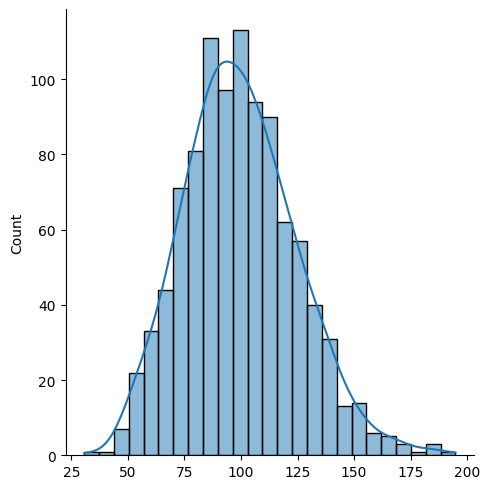

In [51]:
sns.displot(temperatures,kde = True)

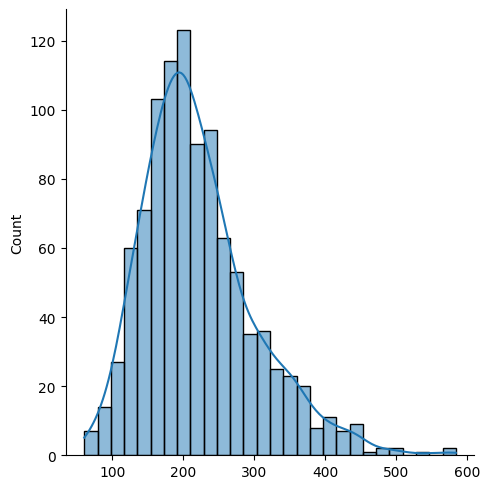

In [52]:
sns.displot(temperatures2,kde = True)

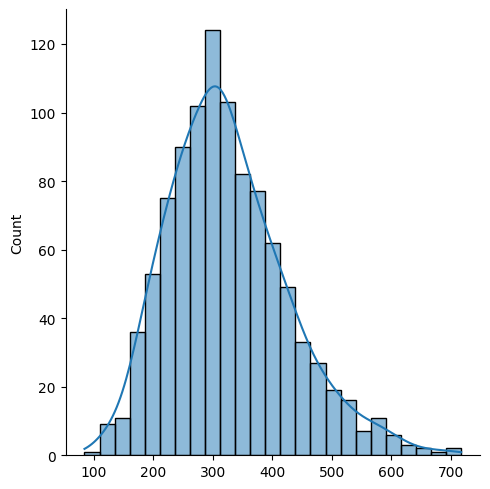

In [53]:
sns.displot(temperatures3,kde = True)

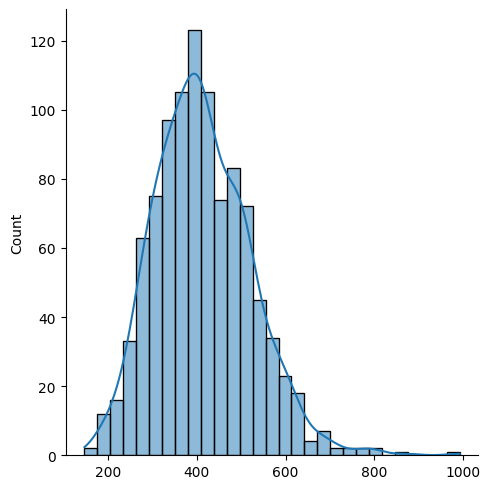

In [54]:
sns.displot(temperatures4,kde = True)

 ## Umbrella Sampling